In [24]:
from haversine import Unit
import haversine as hs
import pandas as pd
import sys
from meteostat import Point, Daily
import matplotlib.pyplot as plt



In [2]:
sys.path.append('../utils/')
from data_cleaning import DataCleaning
from data_extraction import DataExtraction
from feature_extraction import FeatureExtraction

In [3]:
dclean = DataCleaning()
dextract = DataExtraction()
fextract = FeatureExtraction()

In [4]:
clean_df = dextract.load_data('../data/clean_data.csv')
clean_df.head()

,id,order_id,driver_id,driver_action,lat,lng,order_origin,trip_origin,trip_destination,trip_Start_time,trip_end_time
0,1,392001,243828,accepted,6.602207,3.270465,"6.6022066,3.2704649","6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36
1,2,392001,243588,rejected,6.592097,3.287445,"6.5920972,3.2874447","6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36
2,3,392001,243830,rejected,6.596133,3.281784,"6.5961334,3.2817841","6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36
3,4,392001,243539,rejected,6.596142,3.280526,"6.5961416,3.2805263","6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36
4,5,392001,171653,rejected,6.609232,3.288800,"6.6092317,3.2887999","6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36


In [5]:
clean_df = clean_df.dropna()
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1555717 entries, 0 to 1557738
Data columns (total 11 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   id                1555717 non-null  int64  
 1   order_id          1555717 non-null  int64  
 2   driver_id         1555717 non-null  int64  
 3   driver_action     1555717 non-null  object 
 4   lat               1555717 non-null  float64
 5   lng               1555717 non-null  float64
 6   order_origin      1555717 non-null  object 
 7   trip_origin       1555717 non-null  object 
 8   trip_destination  1555717 non-null  object 
 9   trip_Start_time   1555717 non-null  object 
 10  trip_end_time     1555717 non-null  object 
dtypes: float64(2), int64(3), object(6)
memory usage: 142.4+ MB


In [6]:
clean_df = fextract.cordinate_tupple(clean_df,['order_origin','trip_origin','trip_destination'])
clean_df = fextract.convert_to_date(clean_df,['trip_Start_time','trip_end_time'])

In [7]:
features = clean_df.copy()

In [8]:
features['driver_order_dst'] = [fextract.distance_from(loc1,loc2) for loc1, loc2 in zip(clean_df.order_origin,clean_df.trip_origin)]
features['trip_dstance'] = [fextract.distance_from(loc1,loc2) for loc1, loc2 in zip(clean_df.trip_origin,clean_df.trip_destination)] 
features['trip_time'] = (clean_df.trip_end_time - clean_df.trip_Start_time)
features['trip_speed'] = features['trip_dstance'] / features['trip_time'].dt.total_seconds()
features[['driver_order_dst', 'trip_dstance','trip_time','trip_speed']].head()

,driver_order_dst,trip_dstance,trip_time,trip_speed
0,693.62,21048.29,0 days 00:03:37,96.996728
1,1554.09,21048.29,0 days 00:03:37,96.996728
2,788.35,21048.29,0 days 00:03:37,96.996728
3,694.07,21048.29,0 days 00:03:37,96.996728
4,1623.33,21048.29,0 days 00:03:37,96.996728


In [9]:
# features['year'] = clean_df['trip_Start_time'].dt.year
features = fextract.get_ymwdh(features,'trip_Start_time')
features[['month','day','week_day','hour']]

,month,day,week_day,hour
0,7,1,3,9
1,7,1,3,9
2,7,1,3,9
3,7,1,3,9
4,7,1,3,9
...,...,...,...,...
1557734,9,10,4,11
1557735,9,10,4,11
1557736,9,10,4,11
1557737,9,10,4,11


In [11]:
def is_holiday(x,cal):
    if cal.is_holiday(x)==True:
        return 1
    else:
        return 0
def get_holiday(x,cal):
    if cal.is_holiday(x)==True:
        return cal.get_holiday_label(clean_df['trip_Start_time'].iloc[0])
    else:
        return "Not Holiday"

In [12]:
from datetime import date
# from holidays import Nigeria
from workalendar.africa import Nigeria
cal = Nigeria()

In [13]:
is_holiday(date(2021, 7, 20),cal)

1

In [14]:
from datetime import date
# from holidays import Nigeria
from workalendar.africa import Nigeria
cal = Nigeria()
holiday = cal.holidays(2021)

In [15]:
dict={}
for hol in holiday:
    dict[hol[0]] = hol[1]
dict

{datetime.date(2021, 1, 1): 'New year',
 datetime.date(2021, 4, 2): 'Good Friday',
 datetime.date(2021, 4, 5): 'Easter Monday',
 datetime.date(2021, 5, 1): "Workers' Day",
 datetime.date(2021, 5, 13): 'Eid al-Fitr',
 datetime.date(2021, 6, 12): 'Democracy Day',
 datetime.date(2021, 7, 20): 'Eid al-Adha',
 datetime.date(2021, 10, 1): 'Independence Day',
 datetime.date(2021, 12, 25): 'Christmas Day',
 datetime.date(2021, 12, 26): 'Boxing Day'}

In [16]:
for d in clean_df.trip_Start_time:
    if d.date()==date(2021,7,20):
        print(d)

In [17]:
from datetime import date
# from holidays import Nigeria
from workalendar.africa import Nigeria
cal = Nigeria()
def set_holiday(df):
    cal = Nigeria()
    clean_df['trip_Start_time'] = pd.to_datetime(clean_df['trip_Start_time'])
    df['is_holiday'] = df['trip_Start_time'].apply(lambda x:is_holiday(x.date(),cal))
    df['holidays'] =  df['trip_Start_time'].apply(lambda x:get_holiday(x.date(),cal))
    return df
cleand_df = set_holiday(clean_df)

In [18]:
clean_df

,id,order_id,driver_id,driver_action,lat,lng,order_origin,trip_origin,trip_destination,trip_Start_time,trip_end_time,is_holiday,holidays
0,1,392001,243828,accepted,6.602207,3.270465,"(6.6022066, 3.2704649)","(6.6010417, 3.2766339)","(6.4501069, 3.3916154)",2021-07-01 09:30:59,2021-07-01 09:34:36,0,Not Holiday
1,2,392001,243588,rejected,6.592097,3.287445,"(6.5920972, 3.2874447)","(6.6010417, 3.2766339)","(6.4501069, 3.3916154)",2021-07-01 09:30:59,2021-07-01 09:34:36,0,Not Holiday
2,3,392001,243830,rejected,6.596133,3.281784,"(6.5961334, 3.2817841)","(6.6010417, 3.2766339)","(6.4501069, 3.3916154)",2021-07-01 09:30:59,2021-07-01 09:34:36,0,Not Holiday
3,4,392001,243539,rejected,6.596142,3.280526,"(6.5961416, 3.2805263)","(6.6010417, 3.2766339)","(6.4501069, 3.3916154)",2021-07-01 09:30:59,2021-07-01 09:34:36,0,Not Holiday
4,5,392001,171653,rejected,6.609232,3.288800,"(6.6092317, 3.2887999)","(6.6010417, 3.2766339)","(6.4501069, 3.3916154)",2021-07-01 09:30:59,2021-07-01 09:34:36,0,Not Holiday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1557734,1557736,517948,243774,rejected,6.469036,3.566877,"(6.469036, 3.5668767)","(6.443373599999999, 3.5523123)","(6.500608199999999, 3.5981937)",2021-09-10 11:47:26,2021-09-10 13:30:13,0,Not Holiday
1557735,1557737,517948,245447,rejected,6.425431,3.527358,"(6.4254311, 3.5273581)","(6.443373599999999, 3.5523123)","(6.500608199999999, 3.5981937)",2021-09-10 11:47:26,2021-09-10 13:30:13,0,Not Holiday
1557736,1557738,517948,239866,rejected,6.440013,3.525378,"(6.4400128, 3.5253785)","(6.443373599999999, 3.5523123)","(6.500608199999999, 3.5981937)",2021-09-10 11:47:26,2021-09-10 13:30:13,0,Not Holiday
1557737,1557739,517948,243774,rejected,6.469036,3.566877,"(6.469036, 3.5668767)","(6.443373599999999, 3.5523123)","(6.500608199999999, 3.5981937)",2021-09-10 11:47:26,2021-09-10 13:30:13,0,Not Holiday


In [22]:
# Define location for Lagos, Nigeria
lagos = Point(6.5244, 3.3792)

# Define time range for the data
start_date = clean_df['trip_Start_time'].min().to_pydatetime()
# decrease one day from the start date
start_date = start_date - pd.Timedelta(days=1)
end_date = clean_df['trip_Start_time'].max().to_pydatetime()
start_date, end_date

(datetime.datetime(2021, 6, 30, 6, 39, 51),
 datetime.datetime(2022, 2, 27, 9, 7, 59))

In [23]:
# Get daily weather data for Lagos
weather_data = Daily(lagos, start_date, end_date)
weather_data = weather_data.fetch()

# Display the first few rows of the weather data
weather_data.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2021-07-01,27.8,24.0,33.0,0.0,NaN,253.0,10.1,NaN,1014.7,NaN
2021-07-02,27.5,24.9,31.2,NaN,NaN,248.0,9.5,NaN,1014.0,NaN
2021-07-03,25.9,23.0,29.5,NaN,NaN,258.0,11.0,NaN,1014.6,NaN
2021-07-04,25.7,22.0,31.0,NaN,NaN,257.0,8.8,NaN,1015.5,NaN
2021-07-05,27.6,24.0,32.0,NaN,NaN,242.0,8.8,NaN,1015.6,NaN


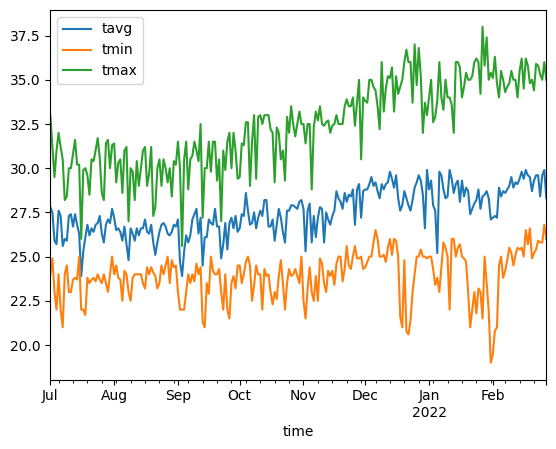

In [26]:
# Plot line chart including average, minimum and maximum temperature
weather_data.plot(y=['tavg', 'tmin', 'tmax'])
plt.show()

In [28]:
# Save the weather data to a CSV file
weather_data.to_csv('../data/legos_weather_data.csv')

In [29]:
features.to_csv('../data/features.csv',index=False)